In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Load the dataset
file_path = "/content/imdb_processed_copy.xlsx"
data = pd.read_excel(file_path)

# Inspect the dataset for missing values
print("Missing values before cleaning:")
print(data.isnull().sum())

# Drop rows with missing values in relevant columns
data_cleaned = data.dropna(subset=['rating', 'runtime', 'year', 'vote', 'country']) #Include 'country' in dropna

# Inspect the dataset after cleaning
print("Missing values after cleaning:")
print(data_cleaned.isnull().sum())

# Preprocess the data
data_cleaned['country'] = data_cleaned['country'].str.strip("[]").str.replace("'", "").str.split(", ")

# Create dummy variables for the `country` column
countries_dummies = data_cleaned['country'].explode().str.strip().str.get_dummies().groupby(level=0).sum()
data_with_countries = pd.concat([data_cleaned.drop(columns=['country']), countries_dummies], axis=1) # Drop country before concatenation

# Define the predictors and target variable
# Get numeric columns explicitly and drop the others
numeric_cols = data_with_countries.select_dtypes(include=np.number).columns.tolist()

# Keep only the dummy variables
country_cols = list(countries_dummies.columns)
X = data_with_countries[country_cols]


# Handle missing values by filling with 0.
X = X.fillna(0)

y = data_with_countries['rating']


# Add a constant for the regression model
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

# Analyze Significant Countries
print("\nSignificant Countries:")
alpha = 0.05  # Significance level
for country, p_value in zip(countries_dummies.columns, model.pvalues[1:]): #skip the const p-value
    if p_value < alpha:
        print(f"  {country}: p-value = {p_value:.3f}")

Missing values before cleaning:
Unnamed: 0       0
title            0
kind             0
genre           67
country        299
language       399
cast           171
director      1311
composer      2729
writer        1247
rating         316
vote           316
year             0
runtime       1653
dtype: int64
Missing values after cleaning:
Unnamed: 0       0
title            0
kind             0
genre           37
country          0
language       110
cast            59
director       899
composer      1979
writer         835
rating           0
vote             0
year             0
runtime          0
dtype: int64


<ipython-input-7-d951aa391e44>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['country'] = data_cleaned['country'].str.strip("[]").str.replace("'", "").str.split(", ")


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     5.676
Date:                Thu, 09 Jan 2025   Prob (F-statistic):           6.97e-59
Time:                        14:19:20   Log-Likelihood:                -10426.
No. Observations:                6381   AIC:                         2.104e+04
Df Residuals:                    6287   BIC:                         2.168e+04
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Load the dataset
file_path = '/content/imdb_processed_copy.xlsx'
data = pd.read_excel(file_path)

# Drop rows where 'vote' is NaN
data = data.dropna(subset=['vote'])

# Display the first few rows of the dataset to understand its structure
print(data.head())

# Define the features and target variable
X = data[['runtime', 'rating', 'year']]  # Features
y = data['vote']  # Target variable

# Handle missing values in features
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Display the model coefficients
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

   Unnamed: 0                                              title  \
0           0                                    Dinosaur Planet   
1           1                                  Get Up and Dance!   
2           2                                              8 Man   
3           3                       What the #$*! Do We (K)now!?   
4           4  Class of Nuke 'Em High Part II: Subhumanoid Me...   

             kind                                              genre  \
0  tv mini series             ['Documentary', 'Animation', 'Family']   
1     video movie                                         ['Family']   
2           movie                               ['Action', 'Sci-Fi']   
3           movie  ['Documentary', 'Comedy', 'Drama', 'Fantasy', ...   
4           movie                     ['Comedy', 'Horror', 'Sci-Fi']   

             country                          language  \
0  ['United States']                       ['English']   
1  ['United States']                      

In [ ]:
import asyncio
import nest_asyncio
import praw
import pandas as pd
from datetime import datetime
from google.colab import userdata
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Install praw if it's not already installed
try:
    import praw
except ModuleNotFoundError:
    print("praw module not found. Installing...")
    !pip install praw
    import praw
try:
    import asyncpraw
except ModuleNotFoundError:
    print("asyncpraw module not found. Installing...")
    !pip install asyncpraw
    import asyncpraw

# Get Reddit API credentials from Colab secrets
try:
    client_id = userdata.get('reddit_client_id')
    client_secret = userdata.get('reddit_secret')
    user_agent = userdata.get('reddit_user')
except KeyError as e:
    raise KeyError(f"Missing Reddit API credential: {e}. Please ensure it's set in Colab secrets.")

# Initialize Reddit API client
async def create_async_reddit_instance():
    return asyncpraw.Reddit(
        client_id=client_id,
        client_secret=client_secret,
        user_agent=user_agent
    )

# Define subreddit
subreddit_name = "SkincareAddiction"
analyzer = SentimentIntensityAnalyzer()

# --- Function to Scrape Posts and Comments ---
async def scrape_reddit_data(subreddit_name, limit=500):
    """
    Scrapes Reddit posts and their comments from a given subreddit using asyncpraw and performs sentiment analysis.

    Args:
        subreddit_name (str): The name of the subreddit to scrape.
        limit (int): The number of posts to retrieve.

    Returns:
        pandas.DataFrame: A DataFrame containing the scraped data.
    """
    reddit = await create_async_reddit_instance()
    subreddit = await reddit.subreddit(subreddit_name)

    posts_data = []
    async for submission in subreddit.new(limit=limit):
        await submission.load() # Load the submission before accessing comments
        post_sentiment = analyzer.polarity_scores(submission.selftext)
        post_info = {
            'post_id': submission.id,
            'post_title': submission.title,
            'post_author': str(submission.author),
            'post_text': submission.selftext,
            'post_created_utc': datetime.utcfromtimestamp(submission.created_utc),
            'post_url': submission.url,
            'post_upvotes': submission.score,
            'post_num_comments': submission.num_comments,
            'post_sentiment': post_sentiment,
            'comments': [] # Initialize the list to store comments
        }
        comment_sentiments = []
        async for comment in submission.comments:
            if isinstance(comment, asyncpraw.models.MoreComments):
                continue
            comment_sentiment = analyzer.polarity_scores(comment.body)
            comment_info = {
                'comment_id': comment.id,
                'comment_author': str(comment.author),
                'comment_text': comment.body,
                'comment_created_utc': datetime.utcfromtimestamp(comment.created_utc),
                'comment_upvotes': comment.score,
                'parent_id': comment.parent_id if hasattr(comment, 'parent_id') else None,  #Parent id may be null
                'comment_sentiment': comment_sentiment
            }
            comment_sentiments.append(comment_sentiment['compound'])
            post_info['comments'].append(comment_info)
        if comment_sentiments:
           avg_comment_sentiment = sum(comment_sentiments) / len(comment_sentiments)
           post_info['avg_comment_sentiment'] = avg_comment_sentiment
        else:
            post_info['avg_comment_sentiment'] = None
        posts_data.append(post_info)
    await reddit.close()
    return pd.DataFrame(posts_data)


# --- Run Scraper and Store Data ---
async def main():
    print("Scraping data...")
    df = await scrape_reddit_data(subreddit_name, limit=500)
    print("Scraping complete.")

    # Convert post_created_utc to local time
    df['post_created_utc'] = df['post_created_utc'].dt.tz_localize('UTC').dt.tz_convert('America/Los_Angeles')
    # Convert comment created utc to local time
    for i, row in df.iterrows():
        for comment in row['comments']:
             comment['comment_created_utc'] = pd.to_datetime(comment['comment_created_utc']).tz_localize('UTC').tz_convert('America/Los_Angeles')


    # --- Display and Save Data ---
    print(df.head())

    # Save data to a CSV file
    file_name = f"{subreddit_name}_reddit_data_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv"
    df.to_csv(file_name, index=False)
    print(f"Data saved to {file_name}")

if __name__ == "__main__":
    nest_asyncio.apply()
    asyncio.run(main())

Scraping data...


<ipython-input-31-baa05e5ac2e1>:103: DeprecationWarning: Using CommentForest as an asynchronous iterator has been deprecated and will be removed in a future version.
  df = await scrape_reddit_data(subreddit_name, limit=500)


Scraping complete.
   post_id                                         post_title  \
0  1hxh5q2  [Selfie] I struggle with body dysmorphic disor...   
1  1hxh3wt  [Product Request] Can someone PLEASE point me ...   
2  1hxgrc8  [Misc] Dupe alert!  Sunday Riley ufo oil - nou...   
3  1hxgqrq     [Sun care] I’m coming home to Australian Gold.   
4  1hxgl52      [sun care] is this sunburn or something else?   

          post_author                                          post_text  \
0            cdavs143  ROUTINE:\n\nAM and PM: CeraVe hydrating cleans...   
1           algorrabb  I just want a 16 ounce bottle of 100% real joj...   
2  tofumeatballcannon                                       That is all!   
3  tofumeatballcannon  I always suspected the botanical mineral spf 5...   
4             tatsbng  in cancun for a week and on day 2 my cheeks st...   

           post_created_utc  \
0 2025-01-09 08:49:10-08:00   
1 2025-01-09 08:47:03-08:00   
2 2025-01-09 08:32:32-08:00   
3 2025-01

Mean Squared Error: 1.235653062896892
R-squared: 0.10185112778380123


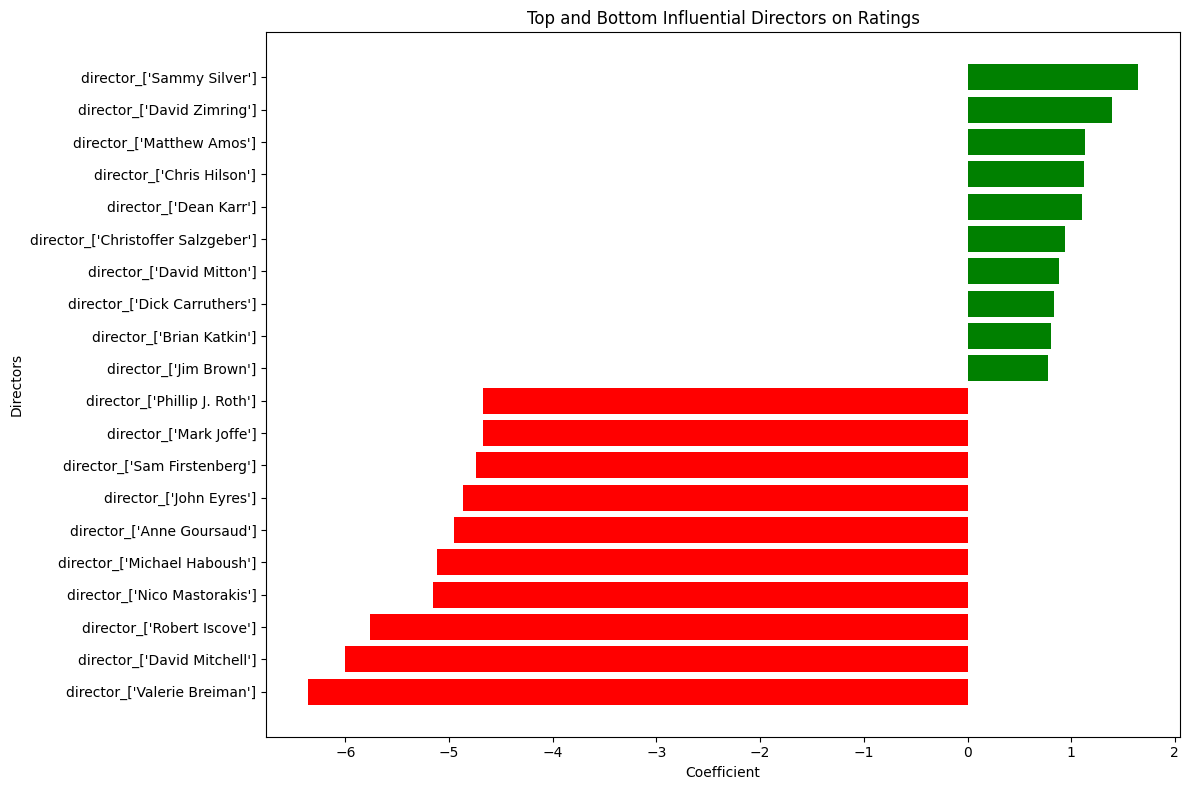

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
data_path = '/content/imdb_processed_copy.xlsx'
data = pd.read_excel(data_path)

# Display the first few rows to understand the structure
data.head()

# Check for missing values
data.isnull().sum()

# Drop rows where 'director' is missing
data = data.dropna(subset=['director'])

# Create a categorical variable for directors with more than one entry
director_counts = data['director'].value_counts()
data['multiple_entries'] = data['director'].apply(lambda x: 1 if director_counts[x] > 1 else 0)

# Filter for directors with more than one entry
directors_with_multiple_entries = director_counts[director_counts > 1].index
filtered_data = data[data['director'].isin(directors_with_multiple_entries)]

# Encode directors with more than one entry
director_dummies = pd.get_dummies(filtered_data['director'], prefix='director', drop_first=True)
data = pd.concat([filtered_data, director_dummies], axis=1)

# Select relevant columns for analysis
# Assuming the dataset contains 'rating', 'runtime', 'vote', and 'year' as well
columns_to_include = ['rating', 'runtime', 'vote', 'year', 'multiple_entries'] + list(director_dummies.columns)
data = data[columns_to_include]
data = data.dropna()

# Define the predictors and target variable
X = data.drop('rating', axis=1)
y = data['rating']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict ratings for the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output evaluation metrics
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Analyze the importance of each predictor
coefficients = pd.DataFrame({
    'Predictor': X.columns,
    'Coefficient': model.coef_
})

# Filter coefficients related to directors
director_coefficients = coefficients[coefficients['Predictor'].str.startswith('director_')]
director_coefficients = director_coefficients.sort_values(by='Coefficient', ascending=False)

# Select the top N and bottom N directors
N = 10  # Adjust N as needed
top_directors = director_coefficients.head(N)
bottom_directors = director_coefficients.tail(N)

# Combine the top and bottom directors
selected_directors = pd.concat([top_directors, bottom_directors])
selected_directors = selected_directors.sort_values(by='Coefficient', ascending=True)

# Visualize director influence
plt.figure(figsize=(12, 8))
bars = plt.barh(selected_directors['Predictor'], selected_directors['Coefficient'], color = np.where(selected_directors['Coefficient'] > 0, 'g', 'r'))
plt.ylabel('Directors')
plt.xlabel('Coefficient')
plt.title('Top and Bottom Influential Directors on Ratings')
plt.tight_layout()
plt.show()

In [ ]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm

# Load the dataset
file_path = "/content/imdb_processed_copy.xlsx"
data = pd.read_excel(file_path)

# Inspect the dataset for missing values
print("Missing values before cleaning:")
print(data.isnull().sum())

# Drop rows with missing values in relevant columns
data_cleaned = data.dropna(subset=['rating', 'runtime', 'year', 'vote'])

# Inspect the dataset after cleaning
print("Missing values after cleaning:")
print(data_cleaned.isnull().sum())

# Define the dependent and independent variables
# Dependent variable: 'rating'
y = data_cleaned['rating']

# Independent variables: 'runtime', 'year', 'vote'
X = data_cleaned[['runtime', 'year', 'vote']]

# Add a constant to the independent variables (for the intercept)
X = sm.add_constant(X)

# Perform linear regression
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())


Missing values before cleaning:
Unnamed: 0       0
title            0
kind             0
genre           67
country        299
language       399
cast           171
director      1311
composer      2729
writer        1247
rating         316
vote           316
year             0
runtime       1653
dtype: int64
Missing values after cleaning:
Unnamed: 0       0
title            0
kind             0
genre           41
country        149
language       245
cast            74
director       976
composer      2078
writer         880
rating           0
vote             0
year             0
runtime          0
dtype: int64
                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     106.5
Date:                Thu, 09 Jan 2025   Prob (F-statistic):    

In [ ]:
!pip install praw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 4.9 MB/s eta 0:00:00


In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00
